## Computing and plotting wind speed with earthkit (GRIB)

In this notebook we will demonstrate how to:

* extract wind components on the 500 hPa pressure level
* compute the wind speed
* change the GRIB header in the resulting fields
* plot the results

Let's import the necessary packages:

In [1]:
import earthkit.data
import earthkit.maps
import numpy as np
import ipywidgets as widgets
from ipywidgets import interactive_output
from datetime import datetime, timedelta

We are going to use wind forecast data from MARS for a set of pressure levels and forecast steps on a 5x5 degree regular latlon grid. If you have retrieved the data earlier, earthkit can read it straight away. Alternatively, earthkit can also retrieve it from MARS.

In [5]:
filename = 'uv.grib'
try:
    g = earthkit.data.from_source('file', filename)
except (FileNotFoundError, FileExistsError):
    yesterday = (datetime.now() - timedelta(1)).strftime('%Y-%m-%d')
    g = earthkit.data.from_source('mars',
                    type='fc', 
                    date = yesterday, 
                    time = 0,
                    param = ['u','v'], 
                    levelist = ['500', '1000'], 
                    levType = 'pl',
                    step = [0, 6, 12, 18],            
                    grid = [5, 5])
    g.save(filename)

mars - INFO   - 20240421.185424 - Welcome to MARS
mars - INFO   - 20240421.185424 - MARS_HOME=/home/usxa/.marsrc/home
mars - INFO   - 20240421.185424 - MARS Client build stamp: 20240410103252
mars - INFO   - 20240421.185424 - MARS Client bundle version: 6.33.18.0
mars - INFO   - 20240421.185424 - MARS Client version: 20240410
mars - INFO   - 20240421.185424 - package mars-client version: 6.33.18
mars - INFO   - 20240421.185424 - package mir version: 1.19.1
mars - INFO   - 20240421.185424 - package odc version: 1.5.0
mars - INFO   - 20240421.185424 - package fdb version: 5.11.30
mars - INFO   - 20240421.185424 - package metkit version: 1.11.7
mars - INFO   - 20240421.185424 - package eckit version: 1.25.2
mars - INFO   - 20240421.185424 - package eccodes version: 2.34.1
retrieve,
type=fc,
date=2024-04-20,
time=0,
param=u/v,
levelist=500/1000,
levType=pl,
step=0/6/12/18,
grid=5/5,
target="/tmp/tmpweu20gcb/mars-retriever-de070cca9ed5494906064a5f654c00cb7ef65c156c92b1275f3ee34d4a18a114.cac

The result is a [GribFieldList](https://earthkit-data.readthedocs.io/en/latest/_api/data/readers/grib/index/index.html#data.readers.grib.index.GribFieldList), which is earthkit's own class to represent GRIB data. We can check the contents of our GribFieldList with [describe()](https://earthkit-data.readthedocs.io/en/latest/_api/data/readers/grib/index/index.html#data.readers.grib.index.GribFieldList.describe), which shows us high level content of the grib.

Alternatively, we can also retrieve similar data from the Copernicus Climate Data Store using the cdsapi through earthkit

In [3]:
# now = datetime.now()
# g = earthkit.data.from_source(
#     'cds',
#     'reanalysis-era5-pressure-levels',
#     {
#         'product_type': 'reanalysis',
#         'format': 'grib',
#         'variable': [
#             'u_component_of_wind', 'v_component_of_wind',
#         ],
#         'pressure_level': [
#             '500', '1000',
#         ],
#         'year': now.year - 1,
#         'month': now.month,
#         'day': now.day,
#         'time': [
#             '00:00', '06:00', '12:00',
#             '18:00',
#         ],
#     },
# )


In [4]:
g.describe()

,,level,date,time,step,paramId,class,stream,type,experimentVersionNumber
shortName,typeOfLevel,,,,,,,,,
u,isobaricInhPa,"1000,500",20240418,0,"0,18,...",131,od,oper,fc,0001
v,isobaricInhPa,"1000,500",20240418,0,"0,18,...",132,od,oper,fc,0001


Next, we **filter** the 500 hPa wind components using the **[sel()](https://earthkit-data.readthedocs.io/en/latest/_api/data/readers/grib/index/index.html#data.readers.grib.index.GribFieldList.sel)** function.

In [5]:
u = g.sel(shortName='u', level=500)
v = g.sel(shortName='v', level=500)

Having extracted the wind components we **compute** the wind speed fields using standard numpy arithmetic. We also generate new metadata for the fields with the right parameter for wind speed (ws)

In [6]:
ws_md = [f.metadata().override(shortName="ws") for f in u]
ws_values = [np.sqrt(i.values*i.values + j.values*j.values) for i, j in zip(u,v)]
ws = earthkit.data.FieldList.from_numpy(ws_values, ws_md)
ws.describe()

,,level,date,time,step,paramId,class,stream,type,experimentVersionNumber
shortName,typeOfLevel,,,,,,,,,
ws,isobaricInhPa,500,20240418,0,"0,18,...",10,od,oper,fc,0001


Finally, we **plot** the first windspeed field using automatic contouring and title settings.

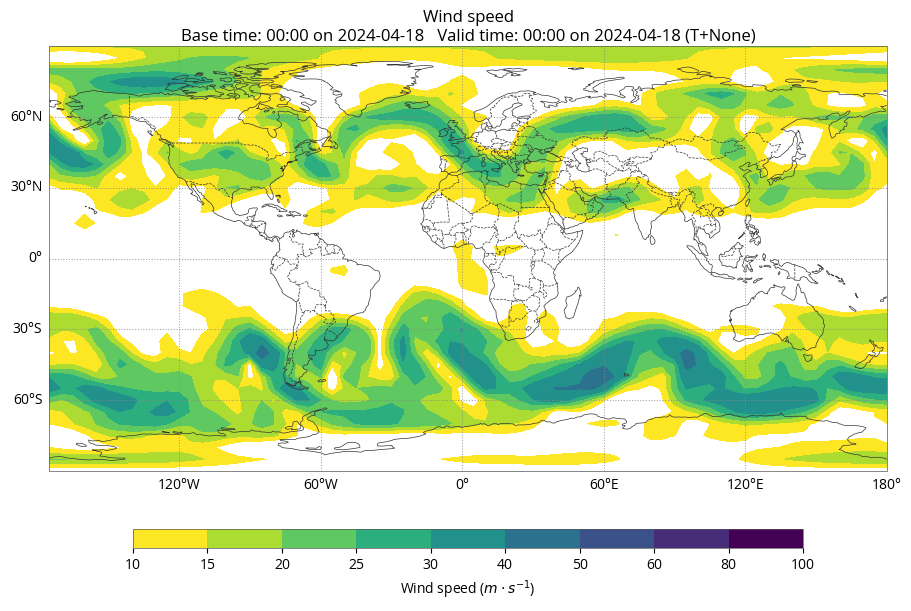

In [7]:
style = earthkit.maps.Style(colors='viridis_r', levels=[10,15,20,25,30,40,50,60,80,100])
earthkit.maps.quickplot(ws[0],style=style)

We can also use ipywidgets to animate the plotting of the GribFieldList

In [8]:
def get_plot(index):
    style = earthkit.maps.Style(colors='viridis_r', levels=[10,15,20,25,30,40,50,60,80,100])
    earthkit.maps.quickplot(ws[index],style=style)
play = widgets.Play(
    value=0,
    min=0,
    max=len(ws)-1,
    step=1,
    interval=1000,
    description="Press play",
    disabled=False
)
interactive_plot = interactive_output(get_plot, {'index': play})
field_slider = widgets.IntSlider(max=len(ws)-1, description="Frame:")
speed_slider = widgets.IntSlider(min=1, max=4, description="Speed:")
speed_slider.observe(lambda change: setattr(play, 'interval', 2000 / speed_slider.value), 'value')
widgets.jslink((play, 'value'), (field_slider, 'value'))
widgets.VBox([interactive_plot, field_slider, speed_slider, play])

This notebook is adapted from [the example in Metview documentation](https://metview.readthedocs.io/en/latest/examples/compute_wind_speed.html).